In [1]:
import pandas as pd  
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
%matplotlib inline   

#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.matplotlib_fname()
from matplotlib import rcParams
from matplotlib.font_manager import FontProperties
font_arial = FontProperties(fname='/Library/Fonts/Arial Unicode.ttf', size=15)
rcParams['axes.unicode_minus']=False

In [5]:
import tushare as ts
ts.set_token('5f576fde2efd1ac4df59161bda0a4f04ac599535db9a1ffec1de21de')
pro = ts.pro_api()

def get_data(code,start='2015-01-01'):
    df=ts.get_k_data(code,start)
    print(df.columns)
    df.index=pd.to_datetime(df.trade_date)
    df=df.sort_index()
    return df

#获取上证指数收盘价、最高、最低价格
df=get_data('300661.SZ')[['open','close','high','low','pre_close','vol']]

Index([], dtype='object')


AttributeError: 'DataFrame' object has no attribute 'trade_date'

In [6]:
#查看包含的技术指标和数学运算函数
#print(ta.get_functions())
#print(ta.get_function_groups())
ta_fun=ta.get_function_groups()
ta_fun.keys()

dict_keys(['Cycle Indicators', 'Math Operators', 'Math Transform', 'Momentum Indicators', 'Overlap Studies', 'Pattern Recognition', 'Price Transform', 'Statistic Functions', 'Volatility Indicators', 'Volume Indicators'])

In [7]:
types=['SMA','EMA','WMA','DEMA','TEMA',
'TRIMA','KAMA','MAMA','T3']
df_ma=pd.DataFrame(df.close)
for i in range(len(types)):
    df_ma[types[i]]=ta.MA(df.close,timeperiod=5,matype=i)
df_ma.tail()

df_ma.loc['2019-08-01':].plot(figsize=(16,6))
ax = plt.gca()  
ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none')   
plt.title('上证指数各种类型移动平均线',fontsize=15, fontproperties=font_arial)
plt.xlabel('')
plt.show()

NameError: name 'df' is not defined

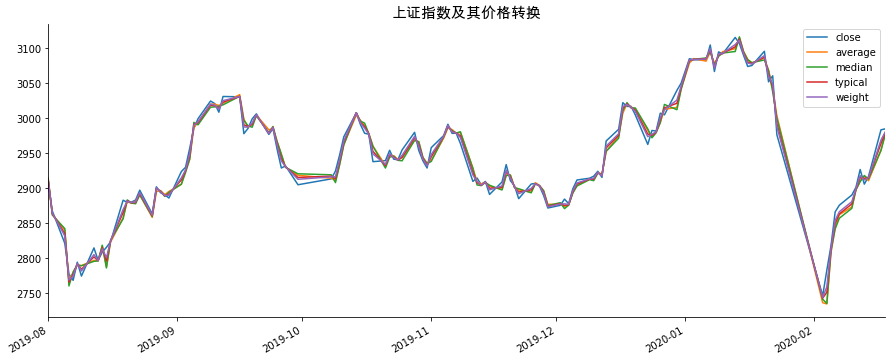

In [7]:
#开盘价，最高价，最低价，收盘价的均值
df['average']=ta.AVGPRICE(df.open,df.high,df.low,df.close)
#最高价，最低价的均值
df['median']=ta.MEDPRICE(df.high,df.low)
#最高价，最低价，收盘价的均值
df['typical']=ta.TYPPRICE(df.high,df.low,df.close)
#最高价，最低价，收盘价的加权，偏重收盘价
df['weight']=ta.WCLPRICE(df.high,df.low,df.close)
df.head()

df.loc['2019-08-01':,['close','average','median','typical','weight']].plot(figsize=(15,6))
ax = plt.gca()  
ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none')   
plt.title('上证指数及其价格转换',fontsize=15,fontproperties=font_arial)
plt.xlabel('')
plt.show()

In [ ]:
# KDJ：https://www.jianshu.com/p/659ff717aad7

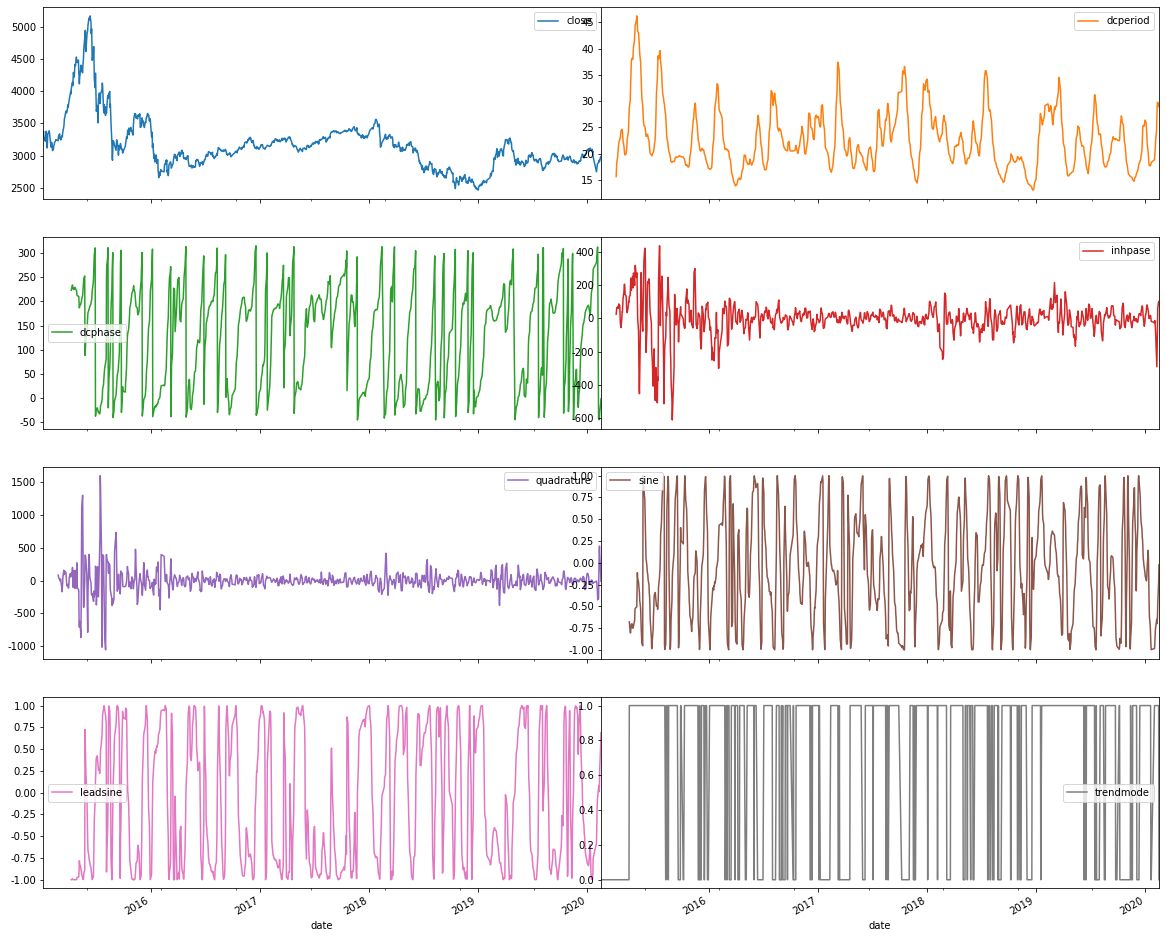

In [9]:
df['dcperiod']=ta.HT_DCPERIOD(df.close)
df['dcphase']=ta.HT_DCPHASE(df.close)
df['inhpase'],df['quadrature']=ta.HT_PHASOR(df.close)
df['sine'],df['leadsine']=sine, leadsine = ta.HT_SINE(df.close)
df['trendmode']=ta.HT_TRENDMODE(df.close)

#将上述函数计算得到的结果进行可视化
df[['close','dcperiod','dcphase','inhpase','quadrature','sine','leadsine','trendmode']].plot(figsize=(20,18),
       subplots = True, layout=(4, 2))
plt.subplots_adjust(wspace=0,hspace=0.2)

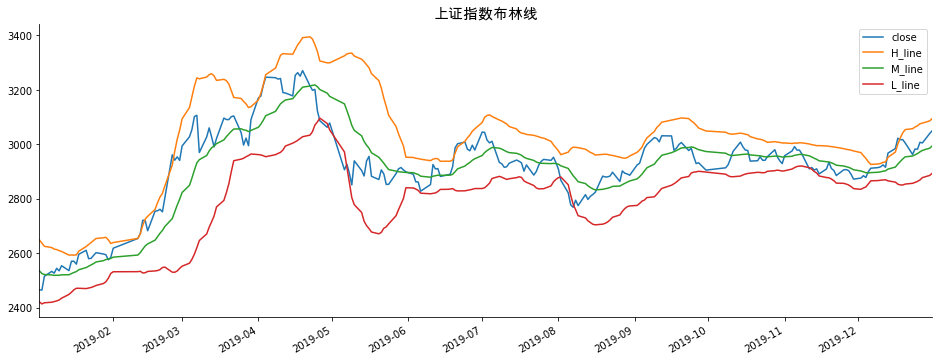

In [5]:
H_line,M_line,L_line =ta.BBANDS(df.close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=2)
df1 = pd.DataFrame(df.close, index=df.index,columns=['close'])
df1['H_line']=H_line
df1['M_line']=M_line
df1['L_line']=L_line
df1.tail()

df1.loc['2019-01-01':'2019-12-31'].plot(figsize=(16,6))
ax = plt.gca()  
ax.spines['right'].set_color('none') 
ax.spines['top'].set_color('none')   
plt.title('上证指数布林线',fontsize=15, fontproperties=font_arial)
plt.xlabel('')
plt.show()

In [ ]:
df['rets'] = df.close - df

In [4]:
df.columns

Index(['open', 'close', 'high', 'low'], dtype='object')

In [ ]:
def MR_Strategy(df,lookback=20,buy_threshold=-1.5,sell_threshold=1.5,cost=0.0):
    '''输入参数：
    df: 包含 open,close,low,high,vol，标的收益率 rets，指数收益率数据hs300
    lookback: 均值回归策略参数，设置统计区间长度，默认20天
    buy_threshold: 买入参数，均值向下偏离标准差的倍数，默认-1.5
    sell_threshold: 卖出参数，均值向上偏离标准差的倍数，默认1.5
    cost: 为手续费 + 滑点价差，可以根据需要进行设置，默认为0.0
    '''
    #计算均值回归策略的Zscore值
    ret_lb=df.rets.rolling(lookback).mean()
    std_lb=df.rets.rolling(lookback).std()
    df['score']=(df.rets-ret_lb)/std_lb
    df.dropna(inplace=True)
    
    #设计买卖信号，为尽量贴近实际，加入涨跌停不能买卖的限制
    #当Zscore值小于-1.5且第二天开盘没有涨停发出买入信号设置为1
    df.loc[(df.score<buy_threshold) &(df['open'] < df['close'].shift(1) * 1.097), 'signal'] = 1
    
    #当Zscore值大于1.5且第二天开盘没有跌停发出卖入信号设置为0
    df.loc[(df.score>sell_threshold) &(df['open'] > df['close'].shift(1) * 0.903), 'signal'] = 0
    df['position']=df['signal'].shift(1)
    df['position'].fillna(method='ffill',inplace=True)
    df['position'].fillna(0,inplace=True)
    
    #根据交易信号和仓位计算策略的每日收益率
    df.loc[df.index[0], 'capital_ret'] = 0
    
    #今天开盘新买入的position在今天的涨幅(扣除手续费)
    df.loc[df['position'] > df['position'].shift(1), 'capital_ret'] = \
                         (df['close'] / df['open']-1) * (1- cost) 
   
    #卖出同理
    df.loc[df['position'] < df['position'].shift(1), 'capital_ret'] = \
                   (df['open'] / df['close'].shift(1)-1) * (1-cost) 
    
    # 当仓位不变时,当天的capital是当天的change * position
    df.loc[df['position'] == df['position'].shift(1), 'capital_ret'] = \
                        df['rets'] * df['position']
    
    #计算标的、策略、指数的累计收益率
    df['capital_line']=(df.capital_ret+1.0).cumprod()
    df['rets_line']=(df.rets+1.0).cumprod()
    df['hs300_line']=(df.hs300+1.0).cumprod()
    return df

In [ ]:
# 根据每次买入的结果,计算相关指标
def trade_indicators(df):
    # 由于篇幅所限，此处代码省略
    #df为策略返回的数据框，包含策略的收益率
    # 计算资金曲线
    # 记录买入或者加仓时的日期和初始资产
    # 输出账户交易各项指标

def performance(df):
    由于篇幅所限，此处代码省略
    #df为策略返回的数据框，包含策略的收益率
    # 计算每一年(月,周)股票,资金曲线的收益
    # 计算策略的年（月，周）胜率
    #计算总收益率、年化收益率和风险指标

#对策略和标的股票累计收益率进行可视化
def plot_performance(df,stock):
    由于篇幅所限，此处代码省略
    #df为策略返回的数据框，包含策略的收益率
    #stock为回测的股票简称

def plot_strategy_signal(df,trade,stock):
    由于篇幅所限，此处代码省略
    #对K线图和买卖信号进行可视化
    #使用pyecharts 0.5.11版本 

#将上述函数整合成一个执行函数
def main(stock,start,end):
    d0=data_feed(stock,start,end)
    d1=MR_Strategy(d0)
    print(f'回测标的：{stock}')
    print(f'回测期间：{start}—{end}')
    trade=trade_indicators(d1)
    performance(d1)
    plot_performance(d1,stock)
    return d1,trade
stock='中国平安'
d1,trade=main(stock,'20151009','20191011')
plot_strategy_signal(d1,trade,stock)